In [1]:
import os
from imp import reload
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage as ski
from skimage import filters
from skimage import io
from skimage.morphology import disk, square
from skimage.filters.rank import mean, otsu
from scipy.ndimage.interpolation import rotate
from scipy import ndimage
from scipy import stats
from tqdm import tqdm  

import warnings
warnings.filterwarnings('ignore')

import utils as ut

plt.set_cmap(cmap=mpl.cm.gray);
mpl.rcParams.update({'font.size': 12});
#plt.rcParams['figure.dpi'] = 150

<Figure size 432x288 with 0 Axes>

In [2]:
#%% Pmat Dataset

#indexes_supine = [1, 8, 9, 10, 11, 12, 15, 16, 17]
indexes_all = np.arange(1,17)

subject = 1
index = 1
fn = 'PmatData/experiment-i/S{}/{}.txt'.format(subject,index)
img_csv = np.genfromtxt(fn)

# discart first 10 and last 10
img_csv = img_csv[10:-10,:]
n_frames,_ = img_csv.shape

# to get size of the read file
print(img_csv.shape)

(62, 2048)


### PMat dataset: Frame #50

Best t: 24
Min: 0.00; Mean: 39.06; Max: 1233.00
Min: 0.00; Mean: 24.52; Max: 255.00


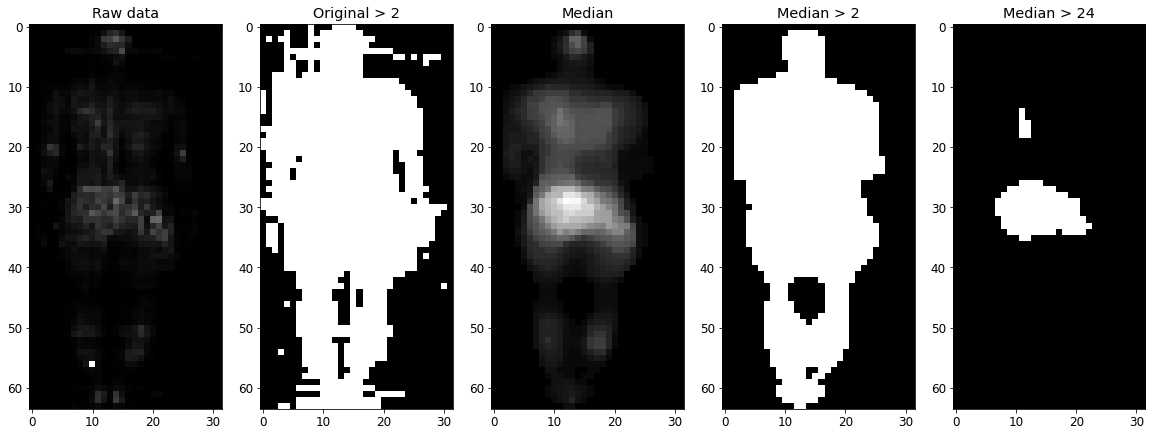

In [3]:
img_frame = img_csv[50,:].reshape((64,32))
best_t = ut.best_threshold(img_frame)

_, img_f_bin_best = ut.pre_processing(img_frame, best_t)

print('Best t:', best_t)
t = 2

img_f, img_f_bin = ut.pre_processing(img_frame, t)

plt.figure(figsize=(20,8))
plt.subplot(1,5,1)
plt.imshow(img_frame)
plt.title('Raw data')
plt.subplot(1,5,2)
plt.imshow(img_frame > t)
plt.title(f'Original > {t}')
plt.subplot(1,5,3)
plt.title('Median')
plt.imshow(img_f)
plt.subplot(1,5,4)
plt.imshow(img_f_bin)
plt.title(f'Median > {t}')
plt.subplot(1,5,5)
plt.imshow(img_f_bin_best)
plt.title(f'Median > {best_t}')

print('Min: {:.2f}; Mean: {:.2f}; Max: {:.2f}'.format(np.min(img_frame), np.mean(img_frame), np.max(img_frame)))
print('Min: {:.2f}; Mean: {:.2f}; Max: {:.2f}'.format(np.min(img_f), np.mean(img_f), np.max(img_f)))

In [4]:
def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')

In [5]:
img_f2 = img_f.astype(np.uint8)
type(img_f2)

numpy.ndarray

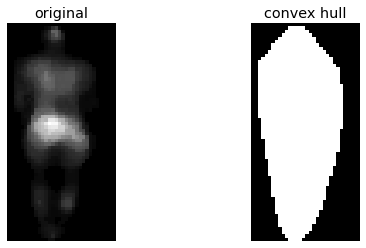

In [6]:
#local_otsu = otsu(img_f2, disk(3))
#thresh_image = img_f2 >= local_otsu

from skimage.morphology import area_opening, convex_hull_image, convex_hull_object

#hull1 = convex_hull_image(img_f > 0, tolerance=10)
hull1 = convex_hull_object(img_f > 0, connectivity=2)
plot_comparison(img_f, hull1, 'convex hull')

In [7]:
#plt.imshow(thresh_image)

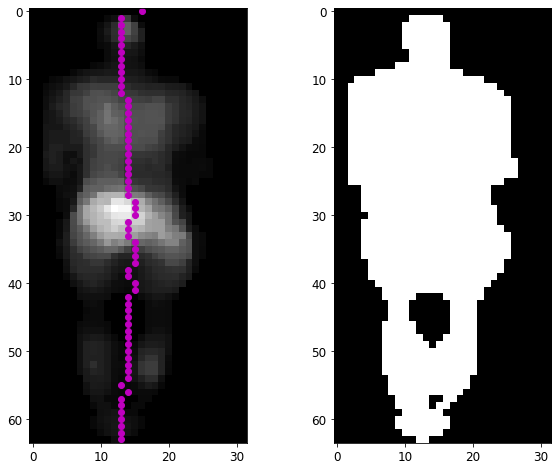

In [8]:
dots_lst = ut.find_medaxis(hull1)
ut.plot_img_marks(img_f, img_f_bin, dots_lst)

#### Loop over all the frames

In [9]:
frames_pts = ut.frames_medaxis(img_csv, dataset='PMat')

100%|█████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 327.19it/s]


### Example: Frame #30

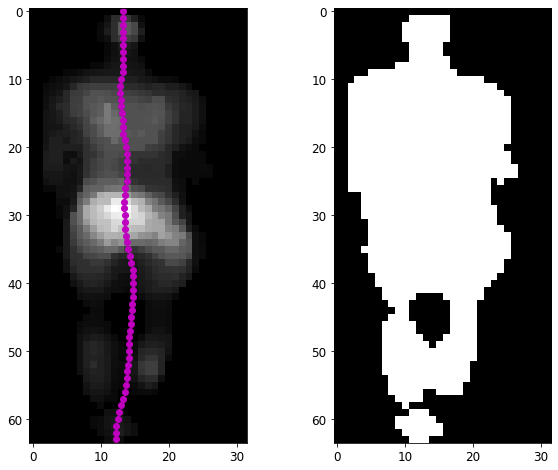

In [10]:
# ploting example frames

frame_number = 30

img_frame, img_bin = ut.get_frame(img_csv, frame_number, dataset='PMat', mask=True)
ut.plot_img_marks(img_frame, img_bin, frames_pts[frame_number])

In [11]:
#frames_pts[0]

In [12]:
left_means, right_means = ut.left_right_analysis(img_csv, frames_pts, dataset='PMat')
prs_mean = np.mean([left_means, right_means], axis=0)

100%|████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 1776.15it/s]


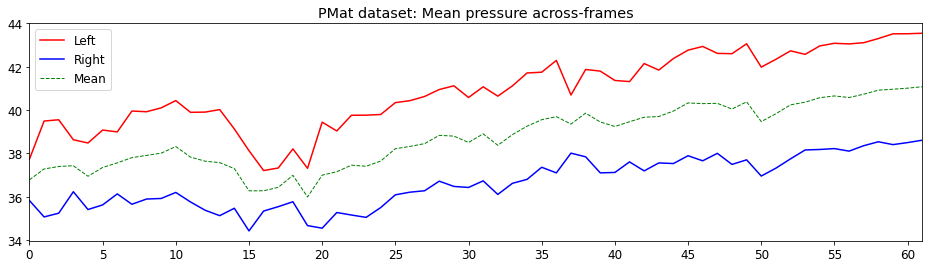

In [13]:
plt.figure(figsize=(16,4))

#plt.subplot(1,4,1)
x = range(len(left_means))

plt.plot(x, left_means, c='r', label='Left')
plt.plot(x, right_means, c='b', label='Right')
plt.plot(x, prs_mean, c='g', lw=1, ls='--', label='Mean')
plt.xticks(np.arange(0,len(left_means),5))
plt.title('PMat dataset: Mean pressure across-frames');
plt.legend()
plt.xlim([0, len(left_means)-1]);

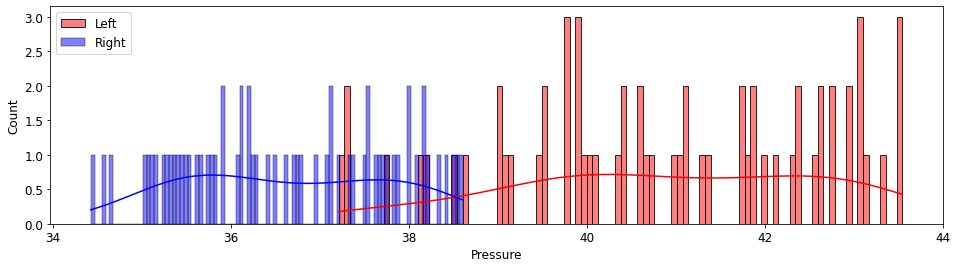

In [14]:
plt.figure(figsize=(16,4))

sns.histplot(left_means, bins=100, color='red', label='Left', kde=True);
sns.histplot(right_means, bins=100, color='blue', label='Right', kde=True);
plt.xlabel('Pressure')
plt.legend();

## Leo's Data

In [15]:
fn_abnormal = 'LeosData/Abnormal_PSMLAB-20210106.xlsx'
fn_normal = 'LeosData/Normal_PSMLAB-20210106.xlsx'

### Abnormal movement

In [16]:
# only if needed to read from excel
#pres_dat = ut.read_excel_data(fn_abnormal)
#ut.data_to_pkl(pres_dat, 'LeosData/Abnormal_PSMLAB-20210106.pkl')

# read previoiusly conoverted pickle
press_data = ut.load_pkl('LeosData/Abnormal_PSMLAB-20210106.pkl')

# discarting: first/last 10
press_data = press_data[10:-10,:,:]

--> Data loaded!


In [17]:
press_data.shape

(173, 118, 48)

### Example: Frame #20, t = 20

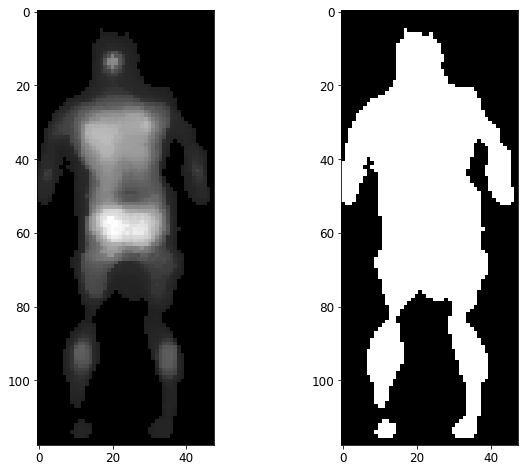

In [18]:
#img, img_bin = ut.get_frame(press_data, frame=20, dataset='XSensor', mask=True, t=best_t)
#ut.plot_img_marks(img, img_bin)

img, img_bin = ut.get_frame(press_data, frame=20, dataset='XSensor', mask=True, t=20)
ut.plot_img_marks(img, img_bin)

In [19]:
best_t = ut.best_threshold(img)
print('best threshold',  best_t)

best threshold 72


In [20]:
frames_pts = ut.frames_medaxis(press_data, dataset='XSensor')

100%|███████████████████████████████████████████████████████████████████████████████| 173/173 [00:01<00:00, 125.52it/s]


### Example: Frame #20, t = 2

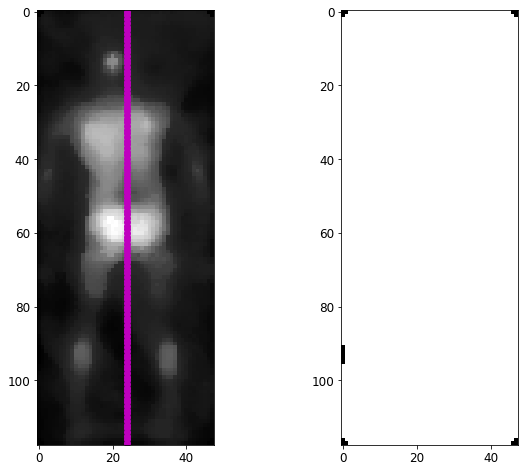

In [21]:
frame_number = 20

img_frame, img_bin = ut.get_frame(press_data, frame_number, dataset='XSensor', mask=True)
ut.plot_img_marks(img_frame, img_bin, frames_pts[frame_number])

In [22]:
# with XSensor left-right are inverted.
# we see the patient from the front side
right_means, left_means = ut.left_right_analysis(press_data, frames_pts, dataset='XSensor')

right_means = ut.rolling_window(right_means, 2)
left_means = ut.rolling_window(left_means, 2)

prs_mean = np.mean([left_means, right_means], axis=0)

100%|███████████████████████████████████████████████████████████████████████████████| 173/173 [00:00<00:00, 682.92it/s]


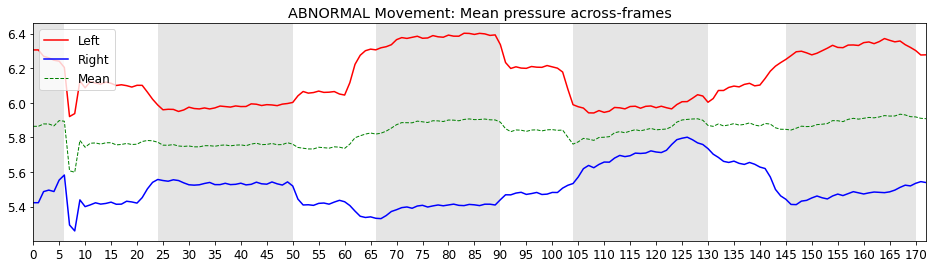

In [23]:
plt.figure(figsize=(16,4))

#plt.subplot(1,4,1)
x = range(len(left_means))

plt.plot(x, left_means, c='r', label='Left')
plt.plot(x, right_means, c='b', label='Right')
plt.plot(x, prs_mean, c='g', lw=1, ls='--', label='Mean')
plt.xticks(np.arange(0,len(left_means),5))
plt.title('ABNORMAL Movement: Mean pressure across-frames');
plt.legend()
# arms off the bed
plt.axvspan(0, 6, color='gray', alpha=0.2, lw=0)
# left arm raised
plt.axvspan(24, 50, color='gray', alpha=0.2, lw=0)
# right arm raised
plt.axvspan(66, 90, color='gray', alpha=0.2, lw=0)
# left leg raised
plt.axvspan(104, 130, color='gray', alpha=0.2, lw=0)
# right leg raised
plt.axvspan(145, 170, color='gray', alpha=0.2, lw=0)
plt.xlim([0, len(left_means)-1]);

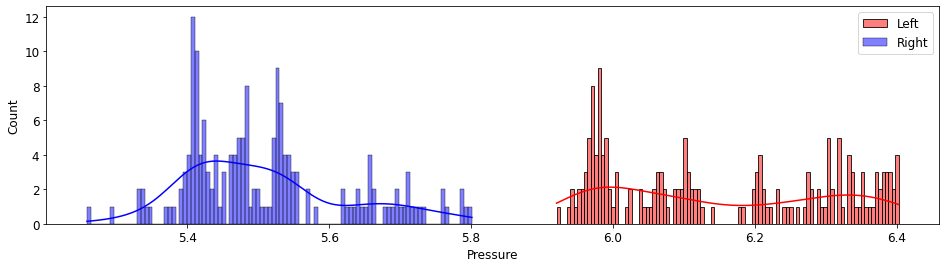

In [24]:
plt.figure(figsize=(16,4))

sns.histplot(left_means, bins=100, color='red', label='Left', kde=True);
sns.histplot(right_means, bins=100, color='blue', label='Right', kde=True);
plt.xlabel('Pressure')
plt.legend();

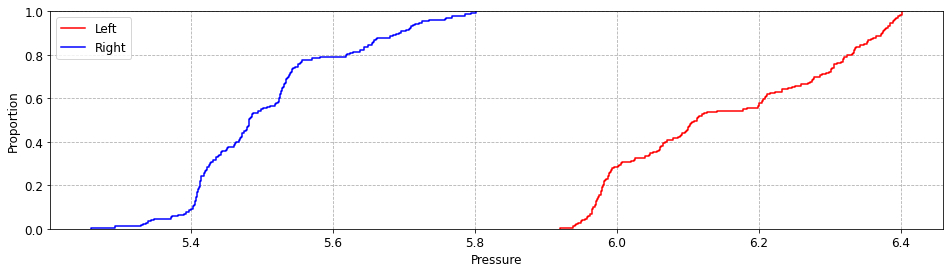

In [25]:
# https://www.geeksforgeeks.org/how-to-make-ecdf-plot-with-seaborn-in-python/
df = pd.DataFrame(data={'Left':left_means, 
                        'Right':right_means})

plt.figure(figsize=(16,4))
sns.ecdfplot(data=df, palette=['red', 'blue'])
plt.grid(ls='--')
plt.xlabel('Pressure');

### Normal movement

In [26]:
#pres_dat = ut.read_excel_data(fn_normal)
#ut.data_to_pkl(pres_dat, 'LeosData/Normal_PSMLAB-20210106.pkl')

# read previoiusly converted pickle
press_data = ut.load_pkl('LeosData/Normal_PSMLAB-20210106.pkl')

# discarting: first/last 10
press_data = press_data[10:-10,:,:]

--> Data loaded!


In [27]:
press_data.shape

(96, 118, 48)

In [28]:
img, img_bin = ut.get_frame(press_data, frame=20, dataset='XSensor', mask=True)

#ut.plot_img_marks(img, img_bin)

In [29]:
frames_pts = ut.frames_medaxis(press_data, dataset='XSensor')

100%|█████████████████████████████████████████████████████████████████████████████████| 96/96 [00:00<00:00, 118.98it/s]


### Example: Frame #50, t = 20

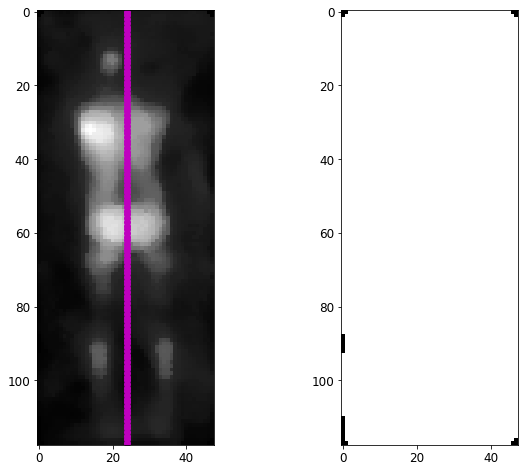

In [30]:
frame_number = 50

img_frame, img_bin = ut.get_frame(press_data, frame_number, dataset='XSensor', mask=True)
ut.plot_img_marks(img_frame, img_bin, frames_pts[frame_number])

In [31]:
right_means, left_means = ut.left_right_analysis(press_data, frames_pts, dataset='XSensor')

#right_means = ut.rolling_window(right_means, 2)
#left_means = ut.rolling_window(left_means, 2)

prs_mean = np.mean([left_means, right_means], axis=0)

100%|█████████████████████████████████████████████████████████████████████████████████| 96/96 [00:00<00:00, 687.54it/s]


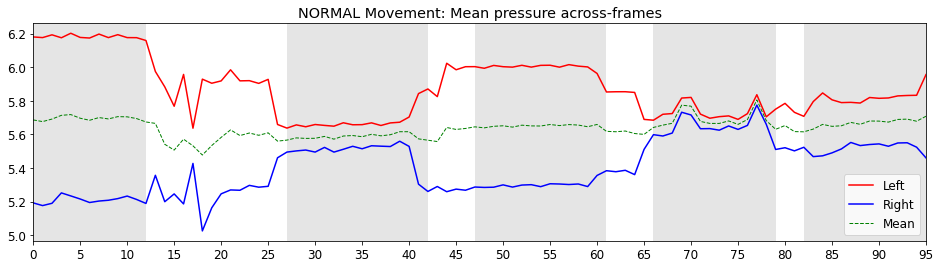

In [32]:
plt.figure(figsize=(16,4))

#plt.subplot(1,4,1)
x = range(len(left_means))

plt.plot(x, left_means, c='r', label='Left')
plt.plot(x, right_means, c='b', label='Right')
plt.plot(x, prs_mean, c='g', lw=1, ls='--', label='Mean')
plt.xticks(np.arange(0,len(left_means),5))
plt.title('NORMAL Movement: Mean pressure across-frames');
plt.legend()
# both arms off the mattress 
plt.axvspan(0, 12, color='gray', alpha=0.2, lw=0)
# left arm raised
plt.axvspan(27, 42, color='gray', alpha=0.2, lw=0)
# right arm raised
plt.axvspan(47, 61, color='gray', alpha=0.2, lw=0)
# left leg raised
plt.axvspan(66, 79, color='gray', alpha=0.2, lw=0)
# right leg raised
plt.axvspan(82, 96, color='gray', alpha=0.2, lw=0)
plt.xlim([0, len(left_means)-1]);

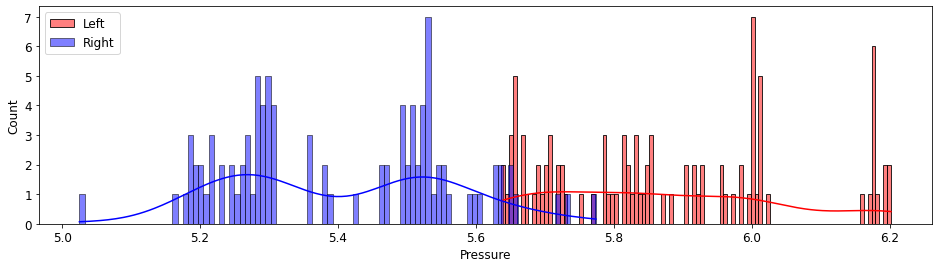

In [33]:
plt.figure(figsize=(16,4))

sns.histplot(left_means, bins=100, color='red', label='Left', kde=True);
sns.histplot(right_means, bins=100, color='blue', label='Right', kde=True);
plt.xlabel('Pressure')
plt.legend();

In [34]:
means_concat = np.concatenate((left_means, right_means))
x_min, x_max = np.min(means_concat), np.max(means_concat)
print('min/max: ', x_min, '/', x_max)
print('len left/right:', len(left_means), len(right_means))

min/max:  5.025035310734463 / 6.201528662420382
len left/right: 96 96


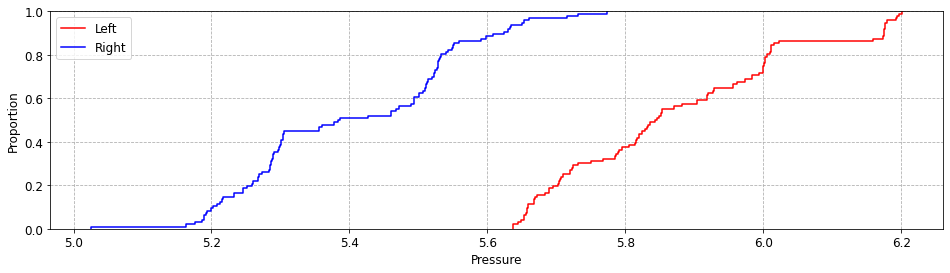

In [35]:
# https://www.geeksforgeeks.org/how-to-make-ecdf-plot-with-seaborn-in-python/
df = pd.DataFrame(data={'Left':left_means, 
                        'Right':right_means})

plt.figure(figsize=(16,4))
sns.ecdfplot(data=df, palette=['red', 'blue'])
plt.grid(ls='--')
plt.xlabel('Pressure');

## Stroke Patient 11ND

**NIHSS**: 8, **XSensor threshold**: 20

**Frames**: 16468 to 20318: 3850 frames

**Weakness**: right side

In [36]:
f_shift = lambda f : f - 16468

In [37]:
base_fn = 'StrokeUnit/P11ND_t0_f16468-20318_PS0008R4S0043_20210224_211657_PSMLAB'

In [38]:
# for test ONLY
#base_fn = 'StrokeUnit/P11ND_t0_f16468-20318_PS0008R4S0043_20210224_211657_PSMLAB_TEST'

# only if need to convert> csv --> pkl
if not os.path.exists(base_fn + '_pkl.pkl'):
    ut.clean_csv(base_fn + '.csv', base_fn + '_csv_clean.csv')
    pres_dat = ut.read_csv_data(base_fn + '_csv_clean.csv')
    ut.data_to_pkl(pres_dat, base_fn + '_pkl.pkl')

press_data = ut.load_pkl(base_fn + '_pkl.pkl')

--> Data loaded!


In [39]:
# find the medaxis ofor each frame
frames_pts = ut.frames_medaxis(press_data, dataset='XSensor', t=20)

100%|█████████████████████████████████████████████████████████████████████████████| 3852/3852 [00:31<00:00, 123.05it/s]


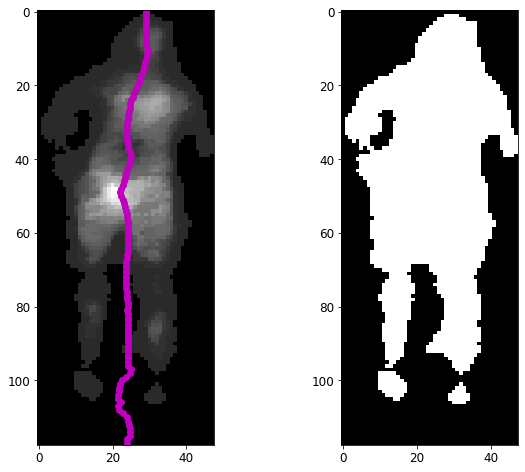

In [40]:
frame_number = 400

img_frame, img_bin = ut.get_frame(press_data, frame_number, dataset='XSensor', mask=True, t=20)
ut.plot_img_marks(img_frame, img_bin, frames_pts[frame_number])

In [41]:
xv = [int(p[1]) for p in frames_pts[frame_number]]
pts_roll = ut.rolling_window(xv, n=10)

pts = [[k,v] for k,v in enumerate(pts_roll)]

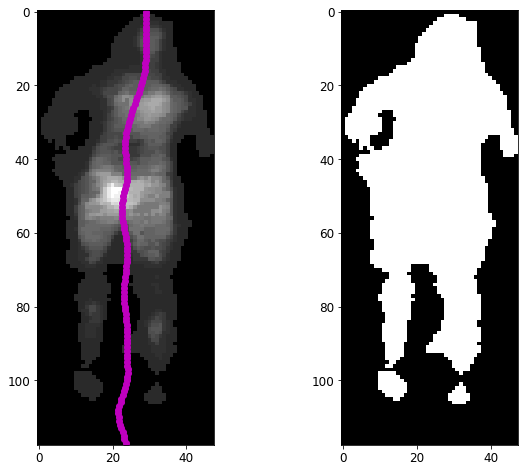

In [42]:
frame_number = 400

img_frame, img_bin = ut.get_frame(press_data, frame_number, dataset='XSensor', mask=True, t=20)
ut.plot_img_marks(img_frame, img_bin, pts)

In [43]:
right_means, left_means = ut.left_right_analysis(press_data, frames_pts, dataset='XSensor')

prs_mean = np.mean([left_means, right_means], axis=0)

right_means = ut.rolling_window(right_means, 8)
left_means = ut.rolling_window(left_means, 8)
prs_mean = ut.rolling_window(prs_mean, 8)

100%|█████████████████████████████████████████████████████████████████████████████| 3852/3852 [00:08<00:00, 461.17it/s]


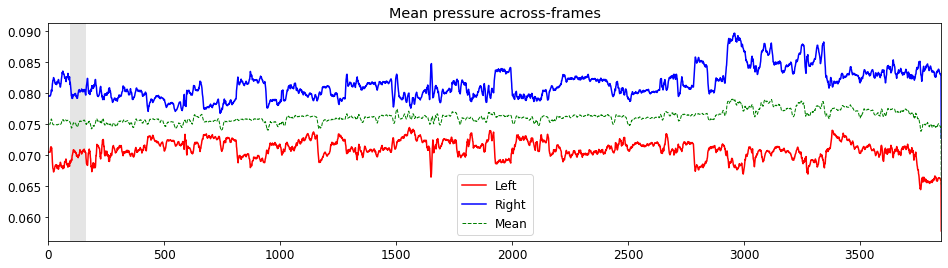

In [44]:
plt.figure(figsize=(16,4))

#plt.subplot(1,4,1)
x = range(len(left_means))

plt.plot(x, left_means, c='r', label='Left')
plt.plot(x, right_means, c='b', label='Right')
plt.plot(x, prs_mean, c='g', lw=1, ls='--', label='Mean')
#plt.xticks(np.arange(0,len(left_means),5))
plt.title('Mean pressure across-frames');
plt.legend()
# legs straith
plt.axvspan(f_shift(16563), f_shift(16629), color='gray', alpha=0.2, lw=0)
# left arm raised
#plt.axvspan(27, 42, color='gray', alpha=0.2, lw=0)
# right arm raised
#plt.axvspan(47, 61, color='gray', alpha=0.2, lw=0)
# left leg raised
#plt.axvspan(66, 79, color='gray', alpha=0.2, lw=0)
# right leg raised
#plt.axvspan(82, 96, color='gray', alpha=0.2, lw=0)
plt.xlim([0, len(left_means)-1]);

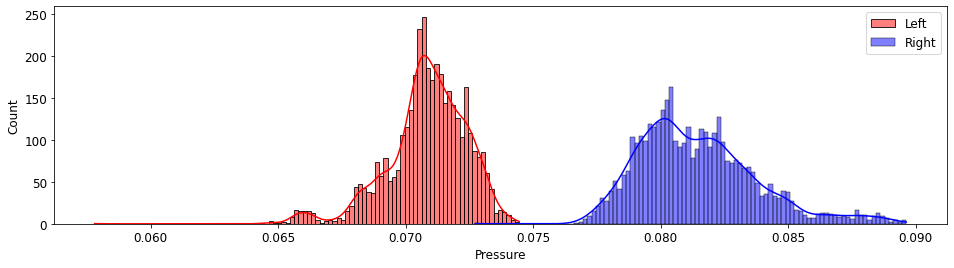

In [45]:
plt.figure(figsize=(16,4))

sns.histplot(left_means, bins=100, color='red', label='Left', kde=True);
sns.histplot(right_means, bins=100, color='blue', label='Right', kde=True);
plt.xlabel('Pressure')
plt.legend();

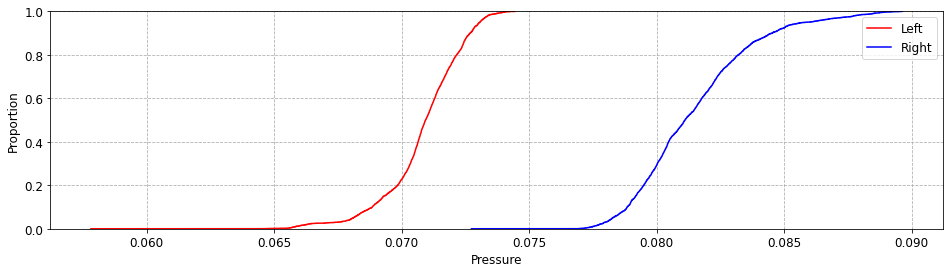

In [46]:
df = pd.DataFrame(data={'Left':left_means, 
                        'Right':right_means})

plt.figure(figsize=(16,4))
sns.ecdfplot(data=df, palette=['red', 'blue'])
plt.grid(ls='--')
plt.xlabel('Pressure');

## Stroke Patient 11ND

**NIHSS**: 8, **XSensor threshold**: 5

**Frames**: 16468 - 20318

In [47]:
base_fn = 'StrokeUnit/P11ND_t5_f16468-20318_PS0008R4S0043_20210224_211657_PSMLAB'

In [48]:
# for test ONLY
#base_fn = 'StrokeUnit/P11ND_t0_f16468-20318_PS0008R4S0043_20210224_211657_PSMLAB_TEST'

# only if need to convert> csv --> pkl
if not os.path.exists(base_fn + '_pkl.pkl'):
    ut.clean_csv(base_fn + '.csv', base_fn + '_csv_clean.csv')
    pres_dat = ut.read_csv_data(base_fn + '_csv_clean.csv')
    ut.data_to_pkl(pres_dat, base_fn + '_pkl.pkl')
    
press_data = ut.load_pkl(base_fn + '_pkl.pkl')

--> Data loaded!


In [49]:
# find the medaxis ofor each frame
frames_pts = ut.frames_medaxis(press_data, dataset='XSensor')

100%|█████████████████████████████████████████████████████████████████████████████| 3851/3851 [00:35<00:00, 109.70it/s]


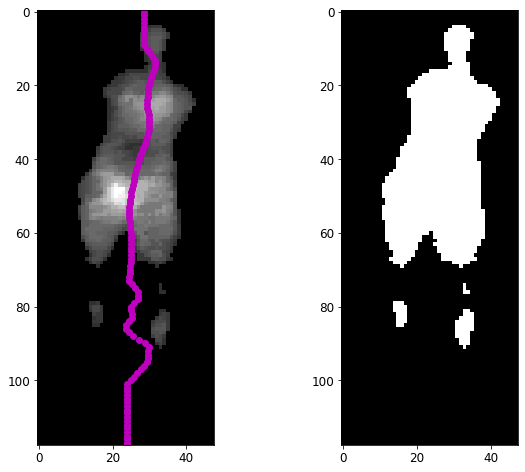

In [50]:
frame_number = 400

img_frame, img_bin = ut.get_frame(press_data, frame_number, dataset='XSensor', mask=True)
ut.plot_img_marks(img_frame, img_bin, frames_pts[frame_number])

In [51]:
right_means, left_means = ut.left_right_analysis(press_data, frames_pts, dataset='XSensor')

prs_mean = np.mean([left_means, right_means], axis=0)

right_means = ut.rolling_window(right_means, 8)
left_means = ut.rolling_window(left_means, 8)
prs_mean = ut.rolling_window(prs_mean, 8)

100%|█████████████████████████████████████████████████████████████████████████████| 3851/3851 [00:07<00:00, 541.10it/s]


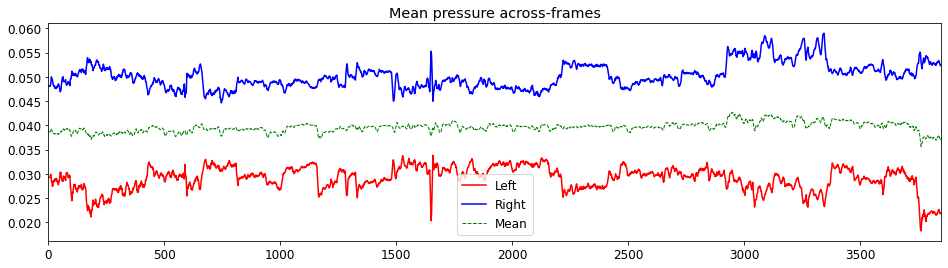

In [52]:
plt.figure(figsize=(16,4))

#plt.subplot(1,4,1)
x = range(len(left_means))

plt.plot(x, left_means, c='r', label='Left')
plt.plot(x, right_means, c='b', label='Right')
plt.plot(x, prs_mean, c='g', lw=1, ls='--', label='Mean')
#plt.xticks(np.arange(0,len(left_means),5))
plt.title('Mean pressure across-frames');
plt.legend()
# both arms off the mattress 
#plt.axvspan(0, 12, color='gray', alpha=0.2, lw=0)
# left arm raised
#plt.axvspan(27, 42, color='gray', alpha=0.2, lw=0)
# right arm raised
#plt.axvspan(47, 61, color='gray', alpha=0.2, lw=0)
# left leg raised
#plt.axvspan(66, 79, color='gray', alpha=0.2, lw=0)
# right leg raised
#plt.axvspan(82, 96, color='gray', alpha=0.2, lw=0)
plt.xlim([0, len(left_means)-1]);

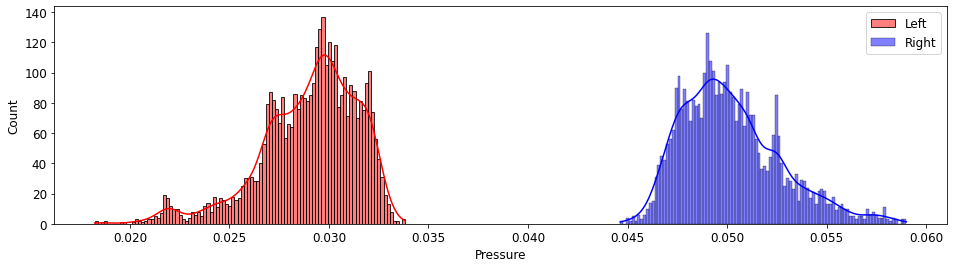

In [53]:
plt.figure(figsize=(16,4))

sns.histplot(left_means, bins=100, color='red', label='Left', kde=True);
sns.histplot(right_means, bins=100, color='blue', label='Right', kde=True);
plt.xlabel('Pressure')
plt.legend();

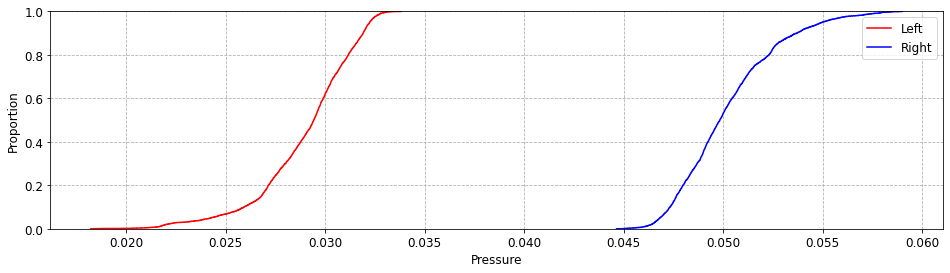

In [54]:
df = pd.DataFrame(data={'Left':left_means, 
                        'Right':right_means})

plt.figure(figsize=(16,4))
sns.ecdfplot(data=df, palette=['red', 'blue'])
plt.grid(ls='--')
plt.xlabel('Pressure');